# WILL NOT BE USED LONG TERM

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] =15 ,9
import numpy as np
import seaborn as sns
import datetime
from matplotlib.pyplot import figure
import os
from pathlib import Path
import shutil
import missingno as msno
qa_path = '../data/QA Checks/'
graphics_path = '../Graphics/'
data_path = '../data/'
code_path = os.getcwd()
today = datetime.date.today()
mon = today.month
day = today.day
year = today.year
date_today = f'{mon}-{day}-{year}'
p1 = pd.to_datetime('05/04/2020')# start phase1
p2 = pd.to_datetime('06/03/2020')# start phase2
p3 = pd.to_datetime('09/25/2020')# start phase3
def stats_col_renamer(dframe):  
    dframe.columns = dframe.columns.str.lower()
    dframe.columns = dframe.columns.str.replace('\s{2,}',' ',regex=True).str.replace('-',' ').str.replace(' ','_').str.replace('[^A-Za-z0-9_]+','',regex=True)
    return dframe

In [2]:
df = pd.read_excel(f'{data_path}COVID Multi-state Model Data set (7-14-20).xlsx', sep=',', sheet_name = 'Project_Dataset')
df.columns = df.columns.str.lower()
df.date = pd.to_datetime(df.date)
df['week'] = df.date.dt.weekofyear

In [40]:
df.columns

Index(['awaiting_testing', 'negative', 'positive', 'percent_positive',
       'total_tested', 'file_name', 'county', 'inconclusive', 'day_of_week',
       'new_negatives', 'new_cases', 'date', 's0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe', 'fips', 'length_of_life_rank', 'quality_of_life_rank',
       'health_behaviors_rank', 'clinical_care_rank',
       'social_economic_factors_rank', 'physical_environment_rank',
       'adult_smoking_percent', 'adult_obesity_percent', 'uninsured_percent',
       'primary_care_physicians_ratio', 'income_inequality_ratio',
       'air_pollution_particulate_matter', 'overcrowding',
       'adult_diabetes_percent', 'median_household_income',
       'percent_over_65_yrs', 'black_percent', 'hispanic_percent',
       'female_percent', 'rural_percent', 'week'],
      dtype='object')

In [42]:
df['new_tests'] = df.new_negatives + df.new_cases

In [43]:
df.new_tests

0          NaN
1        130.0
2         63.0
3         82.0
4         21.0
         ...  
13180     78.0
13181     12.0
13182      8.0
13183     12.0
13184      2.0
Name: new_tests, Length: 13185, dtype: float64

# Evaluating the COVID Line List Data

In [3]:
line_path = f'{data_path}covid data/case line list/'

In [23]:
line_list = pd.read_excel(f'{line_path}/FLORIDA COVID COMPLETE CASE LINE LIST 10-30-2020.xlsx')
line_list.columns = line_list.columns.str.lower()

In [11]:
line_list.shape

(794624, 16)

In [12]:
line_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794624 entries, 0 to 794623
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   County          794624 non-null  object 
 1   Age             793567 non-null  float64
 2   Age_group       794624 non-null  object 
 3   Gender          794624 non-null  object 
 4   Jurisdiction    794624 non-null  object 
 5   Travel_related  794624 non-null  object 
 6   Origin          16923 non-null   object 
 7   EDvisit         772693 non-null  object 
 8   Hospitalized    790668 non-null  object 
 9   Died            16854 non-null   object 
 10  Case_           794624 non-null  object 
 11  Contact         649942 non-null  object 
 12  Case1           794624 non-null  object 
 13  EventDate       794624 non-null  object 
 14  ChartDate       794624 non-null  object 
 15  ObjectId        794624 non-null  int64  
dtypes: float64(1), int64(1), object(14)
memory usage: 97.0+ 

In [69]:
line_list['date'] = pd.to_datetime(line_list.eventdate)
line_list.case1 = pd.to_datetime(line_list.case1).dt.date
line_list.chartdate = pd.to_datetime(line_list.chartdate).dt.date
line_list['week'] = line_list.date.dt.weekofyear
line_list['month'] = line_list.date.dt.month
line_list.date = line_list.date.dt.date
line_list_death = line_list.loc[line_list.died =='Yes']


#Creating Daily case counts
case_count = line_list.groupby(['county','date']).case_.value_counts().to_frame()
case_count.rename(columns={'case_':'case_count'},inplace=True)
case_count.reset_index(inplace=True)
case_count.drop(columns='case_',inplace=True)

#Creating Weekly Case Counts
case_count_week = line_list.groupby(['county','week']).case_.value_counts().to_frame()
case_count_week.rename(columns={'case_':'case_count'},inplace=True)
case_count_week.reset_index(inplace=True)
case_count_week.drop(columns='case_',inplace=True)

#Creating Daily Death Counts
death_count = line_list_death.groupby(['county','date']).case_.value_counts().to_frame()
death_count.rename(columns={'case_':'death_count'},inplace=True)
death_count.reset_index(inplace=True)
death_count.drop(columns='case_',inplace=True)

#Creating Weekly Death Counts
death_count_week = line_list_death.groupby(['county','week']).case_.value_counts().to_frame()
death_count_week.rename(columns={'case_':'death_count'},inplace=True)
death_count_week.reset_index(inplace=True)
death_count_week.drop(columns='case_',inplace=True)

In [76]:
covid_daily = case_count.merge(death_count,on=['county','date'],how='outer')
covid_weekly = case_count_week.merge(death_count_week,on=['county','week'],how='outer')

In [77]:
covid_weekly

,county,week,case_count,death_count
0,Alachua,9,5,NaN
1,Alachua,10,6,NaN
2,Alachua,11,30,NaN
3,Alachua,12,30,NaN
4,Alachua,13,38,1.0
...,...,...,...,...
2410,Washington,40,15,NaN
2411,Washington,41,39,NaN
2412,Washington,42,57,NaN
2413,Washington,43,29,NaN


Text(0.5, 1.0, 'Florida COVID Daily Case Count by County (Line List Data)')

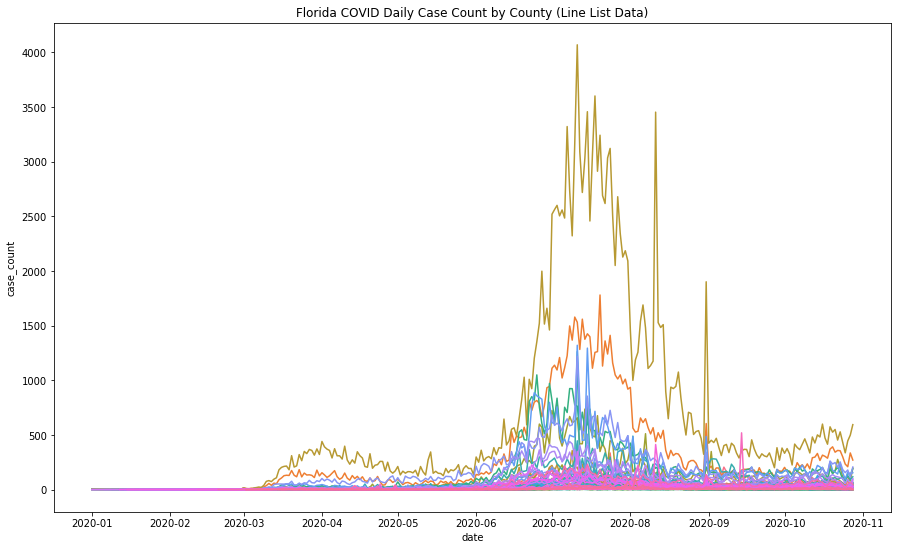

In [13]:
sns.lineplot(x='date', y='case_count', data=case_count,hue= 'county',legend=False)
plt.title('Florida COVID Daily Case Count by County (Line List Data)')

Text(0.5, 1.0, 'Florida COVID Daily Case Count for Palm Beach County (Line List Data)')

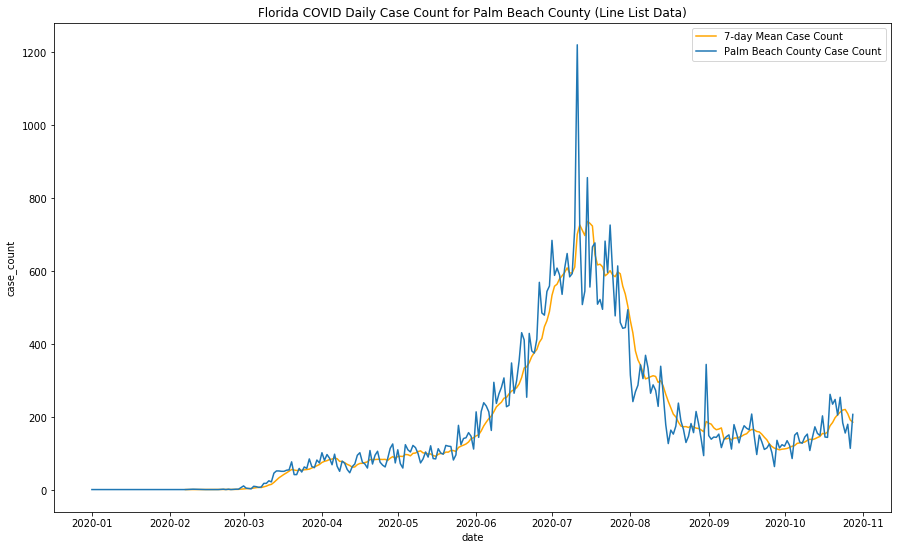

In [100]:
county = 'Palm Beach'
win=7
c = covid_daily.loc[covid_daily.county==county]
mean_case = c.set_index('date').case_count.rolling(window=win).mean()
mean_case.plot(color='orange',label=f'{win}-day Mean Case Count')
sns.lineplot(x='date', y='case_count', data=c,label=f'{county} County Case Count')
plt.title(f'Florida COVID Daily Case Count for {county} County (Line List Data)')

E:\Anaconda\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
E:\Anaconda\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


Text(0.5, 1.0, 'Florida COVID Daily Deaths Count for Palm Beach County (Line List Data)')

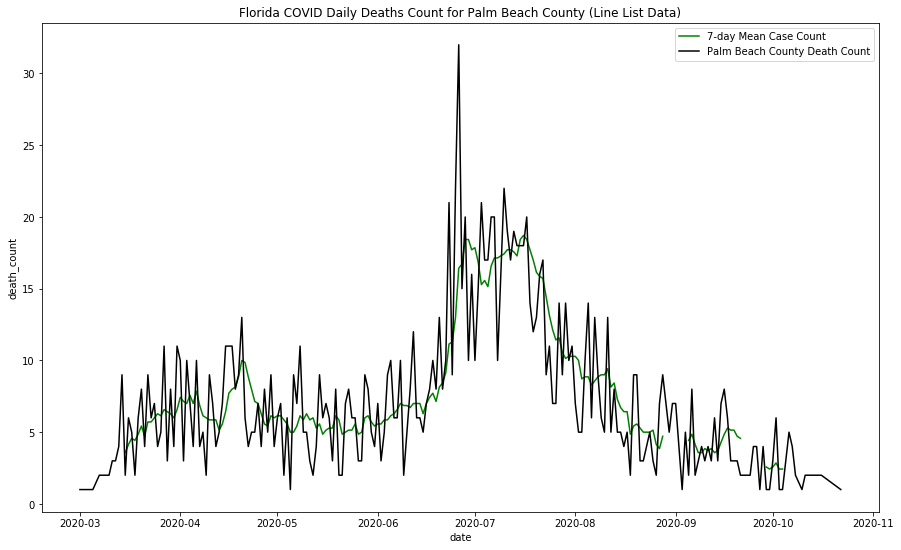

In [101]:
c = covid_daily.loc[covid_daily.county==county]
mean_death = c.set_index('date').death_count.rolling(window=win).mean()
mean_death.plot(color='green',label=f'{win}-day Mean Case Count')
sns.lineplot(x='date', y='death_count', data=c,label=f'{county} County Death Count',c='black')
plt.title(f'Florida COVID Daily Deaths Count for {county} County (Line List Data)')

Text(0.5, 1.0, 'Florida COVID Daily Case Count for Palm Beach County (Line List Data)')

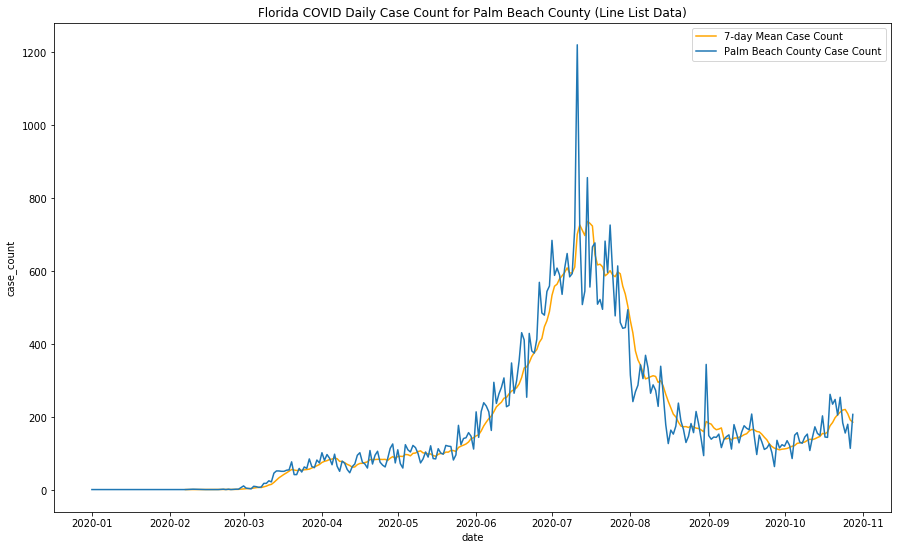

In [83]:
county = 'Palm Beach'
win=7
c = case_count.loc[case_count.county==county]
mean_case = c.set_index('date').case_count.rolling(window=win).mean()
mean_case.plot(color='orange',label=f'{win}-day Mean Case Count')
sns.lineplot(x='date', y='case_count', data=c,label=f'{county} County Case Count')
plt.title(f'Florida COVID Daily Case Count for {county} County (Line List Data)')

Text(0.5, 1.0, 'Florida COVID Total Daily Case Count')

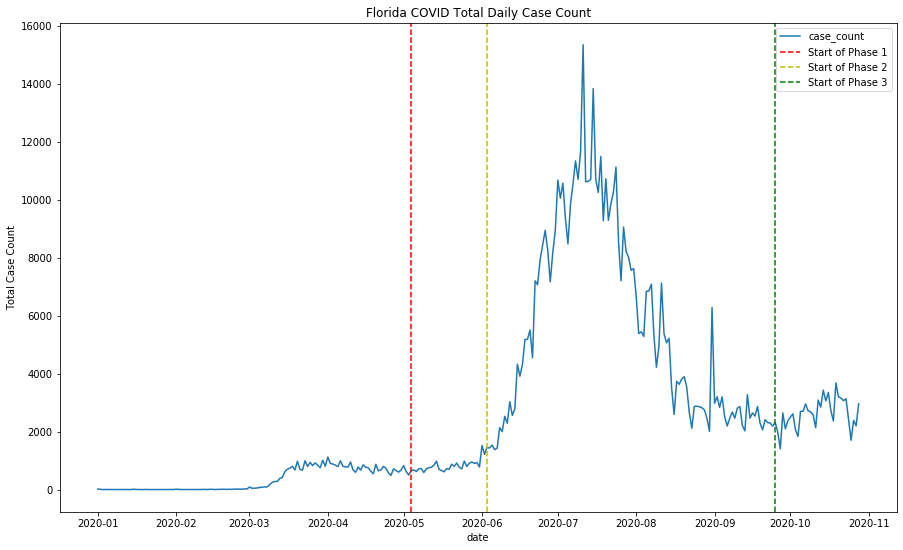

In [105]:
covid_daily.groupby('date').case_count.sum().plot()
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend()
plt.ylabel('Total Case Count')
plt.title(f'Florida COVID Total Daily Case Count')

Text(0.5, 1.0, 'Florida COVID Total Daily Death Count')

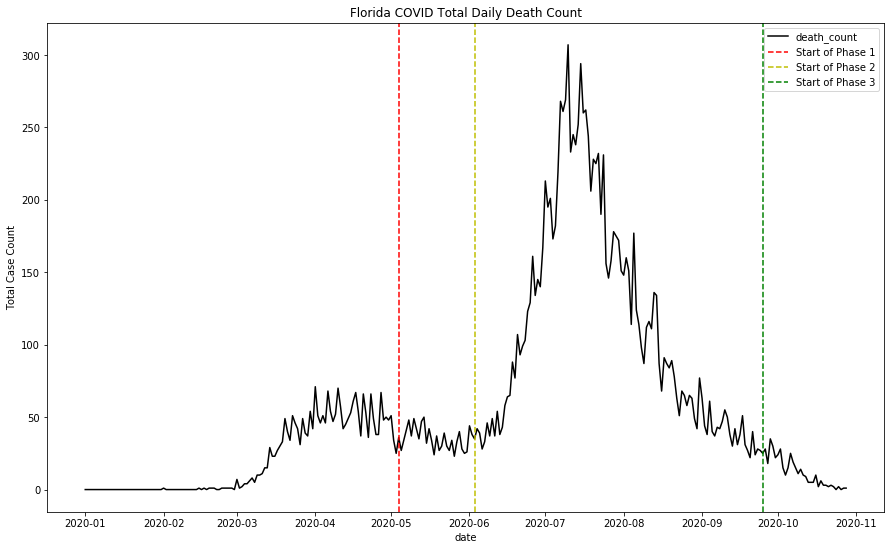

In [106]:
covid_daily.groupby('date').death_count.sum().plot(c='black')
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend()
plt.ylabel('Total Case Count')
plt.title(f'Florida COVID Total Daily Death Count')

In [67]:
sns.lineplot(x = 'date', y ='daily_case_count', hue = 'county', data = d1,legend=False)
plt.title('Florida COVID-19 Daily Case Count by Country')

In [25]:
line_list.shape

(776251, 16)

In [3]:
pop = pd.read_excel(f'{data_path}census/Florida Population Estimates 2020.xlsx')
pop.drop(columns='GrowthRate',inplace=True)
pop.county = pop.county.str.upper()

In [4]:
df['phase'] = 0
df.loc[df.date >= p1, 'phase'] = 1
df.loc[df.date >= p2, 'phase'] = 2
df.loc[df.date >= p3, 'phase'] = 3
df.sort_values(by=['county','date'],inplace=True)

In [5]:
df['phase1'] = 0
df['phase2'] = 0 
df['phase3'] = 0
df.loc[(df.date >= p1) & (df.date < p2),'phase1'] = 1
df.loc[(df.date >= p2) & (df.date < p3),'phase2'] = 1
df.loc[df.date >= p3 ,'phase3'] = 1

In [6]:
df.phase1.value_counts()

0    11145
1     2040
Name: phase1, dtype: int64

In [7]:
df.phase1.value_counts()

0    11145
1     2040
Name: phase1, dtype: int64

In [8]:
df[['daily_neg_count','daily_case_count','daily_test_count']] = df.groupby('county')[['negative','positive','total_tested']].apply(lambda x: x-x.shift(1))

In [9]:
df.date.max()

Timestamp('2020-08-29 00:00:00')

In [10]:
url = 'https://raw.githubusercontent.com/OxCGRT/USA-covid-policy/master/data/OxCGRT_US_subnational_05Aug2020.csv'
cont = pd.read_csv(url, index_col=0)
cont = stats_col_renamer(cont)

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
fl = cont.loc[cont.regionname == 'Florida'].copy()

In [12]:
flags = [x for x in fl.columns if x.find('flag') >= 0]
noflags = [x for x in fl.columns if x.find('flag') <= 0 and x.find('notes') <= 0]

In [13]:
flags
for flag in flags:
    fl[flag].fillna(0,inplace=True)
# or
# fl[['c1_flag', 'c2_flag', 'c3_flag', 'c4_flag', 'c6_flag', 'c7_flag']].fillna(0,inplace=True)

In [14]:
fl.reset_index(inplace=True)
fl.drop(columns=['e1_income_support','CountryName', 'countrycode','regioncode',
       'e1_flag', 'e1_notes', 'e2_debtcontract_relief', 'e2_notes',
       'e3_fiscal_measures', 'e3_notes', 'e4_international_support',
       'e4_notes', 'h1_public_information_campaigns', 'h1_flag', 'h1_notes',
       'h2_testing_policy', 'h2_notes', 'h3_contact_tracing', 'h3_notes',
       'h4_emergency_investment_in_healthcare', 'h4_notes',
       'h5_investment_in_vaccines', 'h5_notes', 'm1_wildcard', 'm1_notes',
       'confirmedcases', 'confirmeddeaths', 'stringencyindex',
       'stringencyindexfordisplay', 'stringencylegacyindex',
       'stringencylegacyindexfordisplay', 'governmentresponseindex',
       'governmentresponseindexfordisplay', 'containmenthealthindex',
       'containmenthealthindexfordisplay', 'economicsupportindex',
       'economicsupportindexfordisplay','jurisdiction'],inplace=True)
fl.dropna(axis=1,how='all',inplace=True)
fl.date = pd.to_datetime(fl.date,format= '%Y%m%d')


In [15]:
fl.columns

Index(['regionname', 'date', 'c1_school_closing', 'c1_flag', 'c1_notes',
       'c2_workplace_closing', 'c2_flag', 'c2_notes',
       'c3_cancel_public_events', 'c3_flag', 'c3_notes',
       'c4_restrictions_on_gatherings', 'c4_flag', 'c4_notes',
       'c5_close_public_transport', 'c5_flag', 'c5_notes',
       'c6_stay_at_home_requirements', 'c6_flag', 'c6_notes',
       'c7_restrictions_on_internal_movement', 'c7_flag', 'c7_notes',
       'c8_international_travel_controls', 'c8_notes'],
      dtype='object')

In [16]:
d1 = df.merge(fl,on='date',how='outer')

In [17]:
d1 = d1.merge(pop,on='county',how='outer')

In [18]:
d1.sort_values(by=['county','date'],inplace=True)

In [19]:
d1.columns

Index(['awaiting_testing', 'negative', 'positive', 'percent_positive',
       'total_tested', 'file_name', 'county', 'inconclusive', 'day_of_week',
       'new_negatives', 'new_cases', 'date', 's0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe', 'fips', 'length_of_life_rank', 'quality_of_life_rank',
       'health_behaviors_rank', 'clinical_care_rank',
       'social_economic_factors_rank', 'physical_environment_rank',
       'adult_smoking_percent', 'adult_obesity_percent', 'uninsured_percent',
       'primary_care_physicians_ratio', 'income_inequality_ratio',
       'air_pollution_particulate_matter', 'overcrowding',
       'adult_diabetes_percent', 'median_household_income',
       'percent_over_65_yrs', 'black_percent', 'hispanic_percent',
       'female_percent', 'rural_percent', 'week', 'phase', 'phase1', 'phase2',
       'phase3', 'daily_neg_count', 'd

In [20]:
d1[[ 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',  'c6_stay_at_home_requirements', 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']] = d1.groupby('county')[[ 'c1_school_closing', 'c2_workplace_closing', 'c3_cancel_public_events', 'c4_restrictions_on_gatherings',
 'c5_close_public_transport',  'c6_stay_at_home_requirements', 'c7_restrictions_on_internal_movement',
 'c8_international_travel_controls']].apply(lambda x: x.ffill())

In [21]:
d1[['s0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe']] = d1[['s0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe']].fillna(np.nan)

In [22]:
d1.drop(columns=['s0101_c01_032e',
       's1501_c02_002e', 's1501_c02_009e', 's1901_c01_012e', 'dp05_0001e',
       'dp05_0037pe', 'dp05_0038pe', 'dp05_0039pe', 'dp05_0044pe',
       'dp05_0052pe'],inplace=True)

In [23]:
d1.date = d1.date.dt.date

In [24]:
d1.to_excel(f'{data_path}NEW Data Set (Oxford Control Measures).xlsx')

# Trend Analysis

Text(0.5, 1.0, 'Florida COVID-19 Daily Case Count by Country')

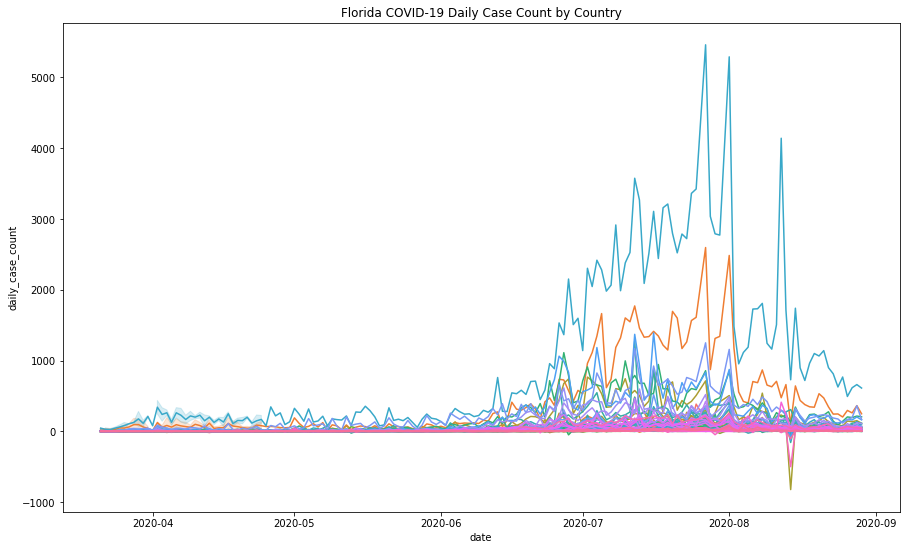

In [25]:
sns.lineplot(x = 'date', y ='daily_case_count', hue = 'county', data = d1,legend=False)
plt.title('Florida COVID-19 Daily Case Count by Country')

Text(0.5, 1.0, 'Florida COVID-19 Daily Positive Ratio Count by Country')

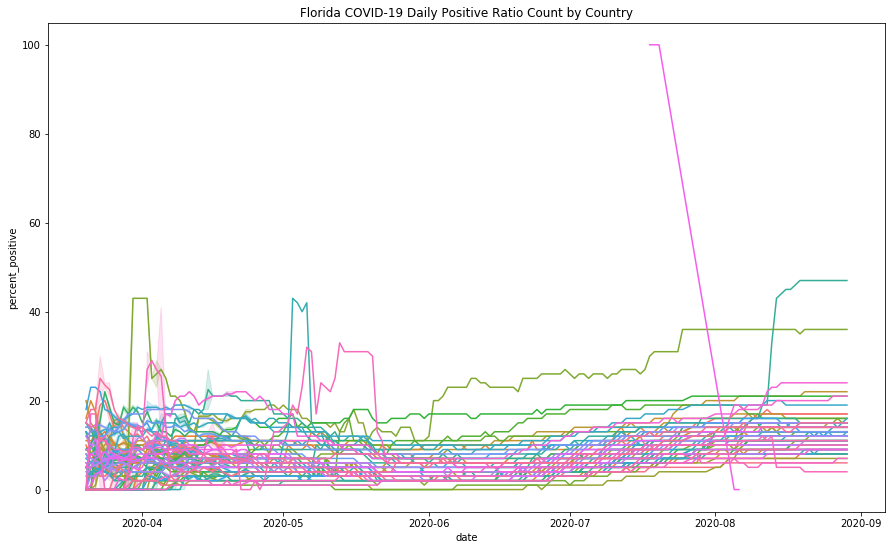

In [26]:
sns.lineplot(x = 'date', y ='percent_positive', hue = 'county', data = d1,legend=False)
plt.title('Florida COVID-19 Daily Positive Ratio Count by Country')

In [27]:
df_indexed = d1.set_index('date')

Text(0.5, 1.0, 'Florida COVID-19 Daily 7-Day Rolling Mean & STD of Case Count')

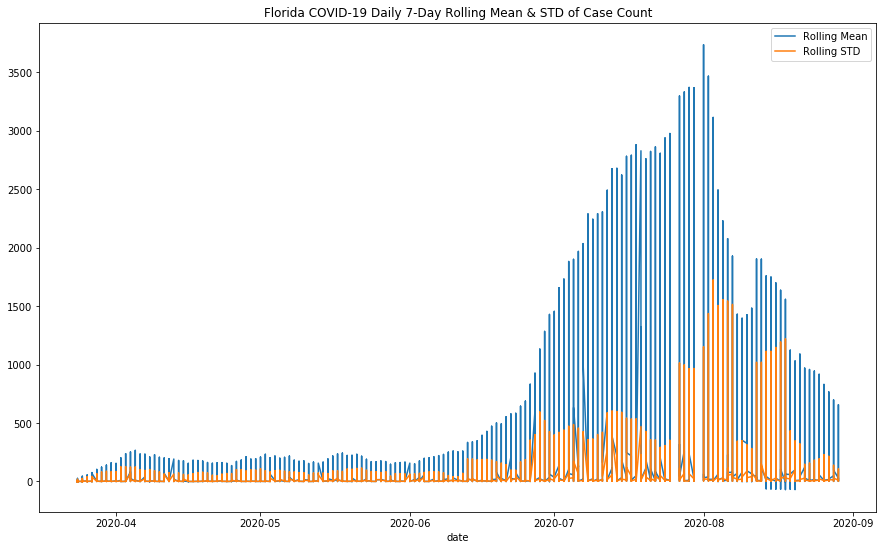

In [28]:
rolmean_case = df_indexed.daily_case_count.rolling(window=7).mean()
rolstd_case = df_indexed.daily_case_count.rolling(window=7).std()
rolmean_case.plot(label='Rolling Mean')
rolstd_case.plot( label='Rolling STD')
plt.legend(loc='best')
plt.title('Florida COVID-19 Daily 7-Day Rolling Mean & STD of Case Count')

Text(0.5, 1.0, 'Florida COVID-19 Daily 7-Day Rolling Mean & STD of Positivity Ratio')

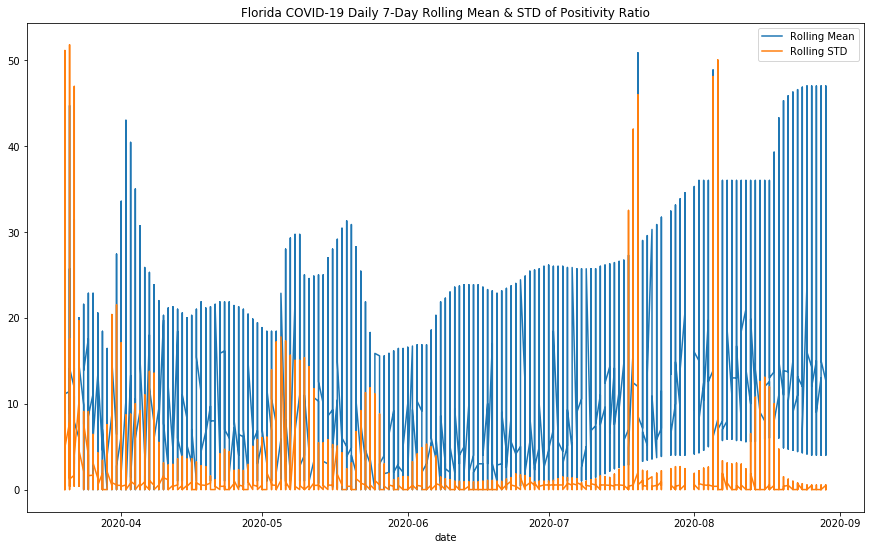

In [29]:
rolmean_pos = df_indexed.percent_positive.rolling(window=7).mean()
rolstd_pos = df_indexed.percent_positive.rolling(window=7).std()
rolmean_pos.plot(label='Rolling Mean')
rolstd_pos.plot( label='Rolling STD')
plt.legend(loc='best')
plt.title('Florida COVID-19 Daily 7-Day Rolling Mean & STD of Positivity Ratio')

In [30]:
# Descriptive Analysis

Text(0.5, 1.0, 'Distribution of COVID-19 Case Counts')

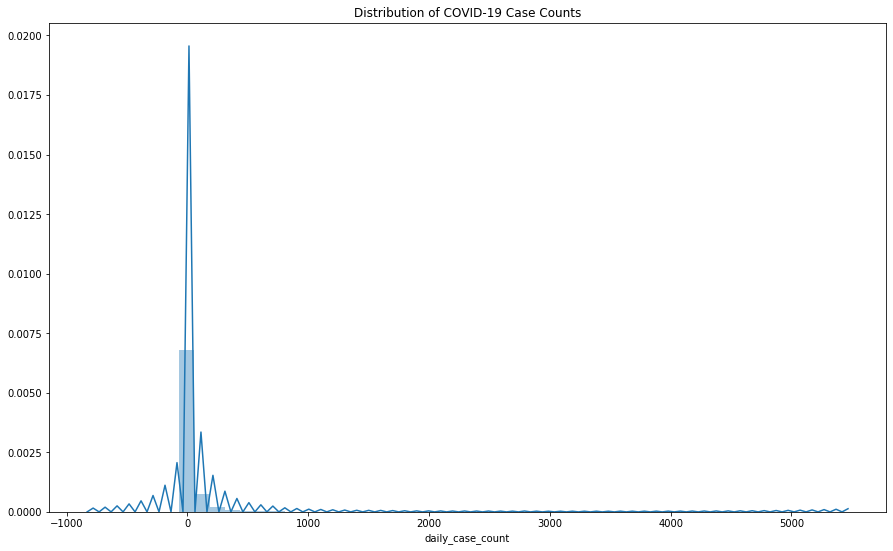

In [128]:
sns.distplot(df.daily_case_count)
plt.title('Distribution of COVID-19 Case Counts')

Text(0.5, 1.0, 'Distribution of COVID-19 Positivity Ratio')

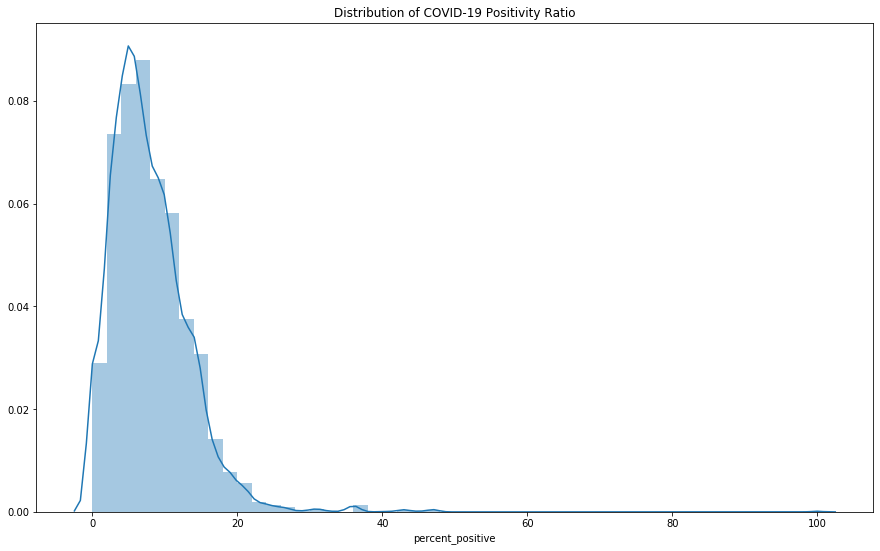

In [127]:
sns.distplot(df.percent_positive)
plt.title('Distribution of COVID-19 Positivity Ratio')

In [32]:
d1[['daily_case_count','percent_positive']].describe()

,daily_case_count,percent_positive
count,13116.000000,13185.000000
mean,46.633272,7.869170
std,193.496147,5.540953
min,-822.000000,0.000000
25%,0.000000,4.000000
50%,4.000000,7.000000
75%,23.000000,11.000000
max,5461.000000,100.000000


In [33]:
d1.groupby('county')['positive'].sum()

county
ALACHUA       236308.0
BAKER          35044.0
BAY           192404.0
BRADFORD       25267.0
BREVARD       336264.0
                ...   
UNKNOWN        27885.0
VOLUSIA       433303.0
WAKULLA        31615.0
WALTON         68664.0
WASHINGTON     36170.0
Name: positive, Length: 69, dtype: float64

In [136]:
most_case = d1.daily_case_count.max()
max_sum_case = d1.groupby('date')['daily_case_count'].sum().max()
daily_sum_case = d1.groupby('date')[['daily_neg_count', 'daily_case_count', 'daily_test_count']].sum()
daily_sum_case['pr'] = daily_sum_case.daily_case_count/daily_sum_case.daily_test_count

In [135]:
d1.columns

Index(['awaiting_testing', 'negative', 'positive', 'percent_positive',
       'total_tested', 'file_name', 'county', 'inconclusive', 'day_of_week',
       'new_negatives', 'new_cases', 'date', 'fips', 'length_of_life_rank',
       'quality_of_life_rank', 'health_behaviors_rank', 'clinical_care_rank',
       'social_economic_factors_rank', 'physical_environment_rank',
       'adult_smoking_percent', 'adult_obesity_percent', 'uninsured_percent',
       'primary_care_physicians_ratio', 'income_inequality_ratio',
       'air_pollution_particulate_matter', 'overcrowding',
       'adult_diabetes_percent', 'median_household_income',
       'percent_over_65_yrs', 'black_percent', 'hispanic_percent',
       'female_percent', 'rural_percent', 'week', 'phase', 'phase1', 'phase2',
       'phase3', 'daily_neg_count', 'daily_case_count', 'daily_test_count',
       'regionname', 'c1_school_closing', 'c1_flag', 'c1_notes',
       'c2_workplace_closing', 'c2_flag', 'c2_notes',
       'c3_cancel_public_

Peak in total daily case counts

In [139]:
daily_sum_case.loc[daily_sum_case.daily_case_count == max_sum_case]

,daily_neg_count,daily_case_count,daily_test_count
date,,,
2020-08-01,81677.0,18649.0,100787.0


In [36]:
d1.county.nunique()

69

In [37]:
d1.date.max(),d1.date.min()

(datetime.date(2020, 8, 29), datetime.date(2020, 1, 1))

In [38]:
rolmean_case.max()
rolmean_case.loc[rolmean_case==rolmean_case.max()]

date
2020-08-01    3734.142857
Name: daily_case_count, dtype: float64

In [41]:
d1.columns

Index(['awaiting_testing', 'negative', 'positive', 'percent_positive',
       'total_tested', 'file_name', 'county', 'inconclusive', 'day_of_week',
       'new_negatives', 'new_cases', 'date', 'fips', 'length_of_life_rank',
       'quality_of_life_rank', 'health_behaviors_rank', 'clinical_care_rank',
       'social_economic_factors_rank', 'physical_environment_rank',
       'adult_smoking_percent', 'adult_obesity_percent', 'uninsured_percent',
       'primary_care_physicians_ratio', 'income_inequality_ratio',
       'air_pollution_particulate_matter', 'overcrowding',
       'adult_diabetes_percent', 'median_household_income',
       'percent_over_65_yrs', 'black_percent', 'hispanic_percent',
       'female_percent', 'rural_percent', 'week', 'phase', 'phase1', 'phase2',
       'phase3', 'daily_neg_count', 'daily_case_count', 'daily_test_count',
       'regionname', 'c1_school_closing', 'c1_flag', 'c1_notes',
       'c2_workplace_closing', 'c2_flag', 'c2_notes',
       'c3_cancel_public_

In [96]:
d1.sort_values(by=['county','date'], inplace=True)

In [125]:
fl.c2_workplace_closing.value_counts()

2.0    141
0.0     76
Name: c2_workplace_closing, dtype: int64

In [141]:
dsc = daily_sum_case.reset_index()
dsc.date = pd.to_datetime(dsc.date)
dsc.daily_case_count = dsc.daily_case_count.astype(int)
dsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              242 non-null    datetime64[ns]
 1   daily_neg_count   242 non-null    float64       
 2   daily_case_count  242 non-null    int32         
 3   daily_test_count  242 non-null    float64       
 4   pr                160 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1)
memory usage: 8.6 KB


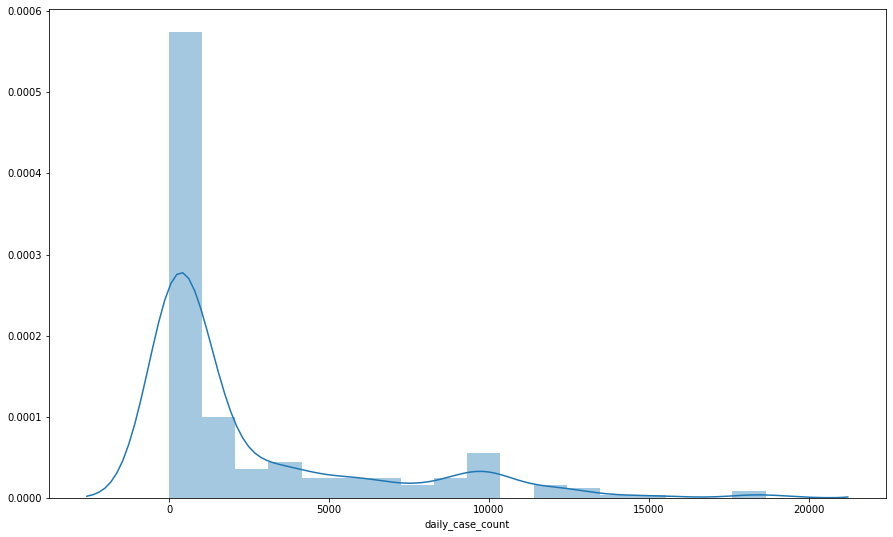

In [143]:
sns.distplot(dsc.daily_case_count)

In [144]:
dsc

,date,daily_neg_count,daily_case_count,daily_test_count,pr
0,2020-01-01,0.0,0,0.0,NaN
1,2020-01-02,0.0,0,0.0,NaN
2,2020-01-03,0.0,0,0.0,NaN
3,2020-01-04,0.0,0,0.0,NaN
4,2020-01-05,0.0,0,0.0,NaN
...,...,...,...,...,...
237,2020-08-25,16689.0,2665,19394.0,0.137414
238,2020-08-26,23006.0,2937,25895.0,0.113420
239,2020-08-27,21234.0,3229,24449.0,0.132071
240,2020-08-28,26494.0,3732,30246.0,0.123388


E:\Anaconda\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
E:\Anaconda\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


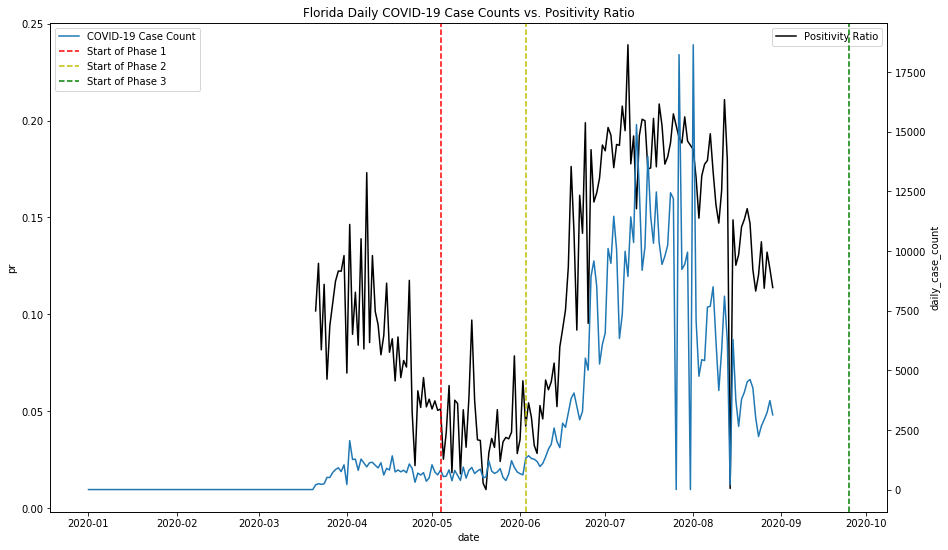

In [147]:
sns.lineplot(x='date' ,y='pr',c='black', data=dsc, label='Positivity Ratio' )
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2,label='COVID-19 Case Count')
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.title('Florida Daily COVID-19 Case Counts vs. Positivity Ratio')
plt.legend(loc='best')

E:\Anaconda\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
E:\Anaconda\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


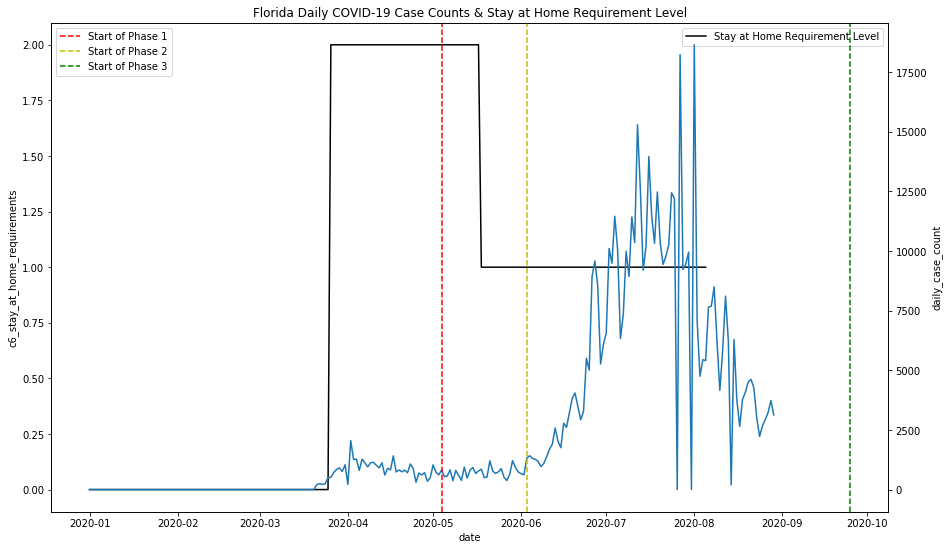

In [89]:
sns.lineplot(x='date' ,y='c6_stay_at_home_requirements',c='black', data=fl, label='Stay at Home Requirement Level' )
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2)
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.title('Florida Daily COVID-19 Case Counts & Stay at Home Requirement Level')
plt.legend(loc='best')

E:\Anaconda\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
E:\Anaconda\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


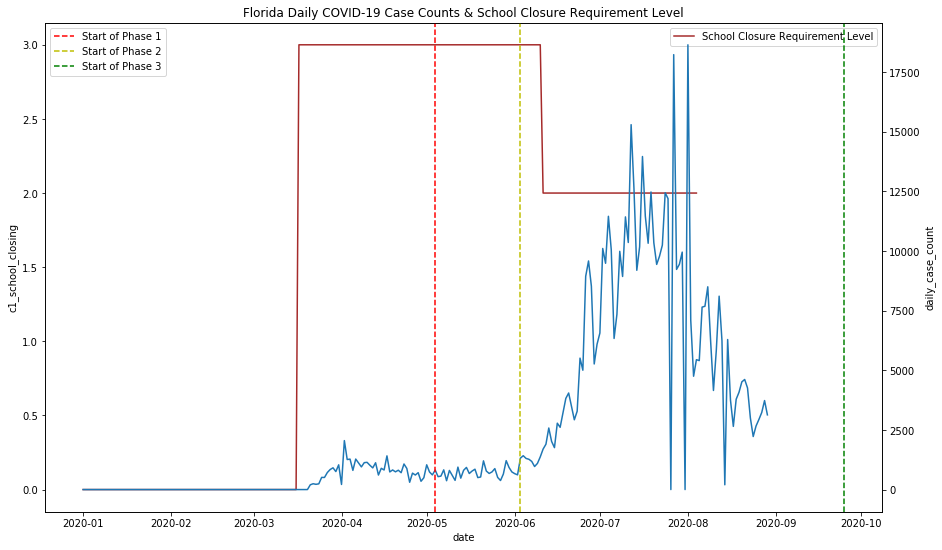

In [90]:
sns.lineplot(x='date' ,y='c1_school_closing', data=fl,c='brown', label='School Closure Requirement Level' )
plt.title('Florida Daily COVID-19 Case Counts & School Closure Requirement Level')
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2)
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend(loc='best')

E:\Anaconda\lib\site-packages\seaborn\relational.py:823: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
E:\Anaconda\lib\site-packages\seaborn\relational.py:834: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)


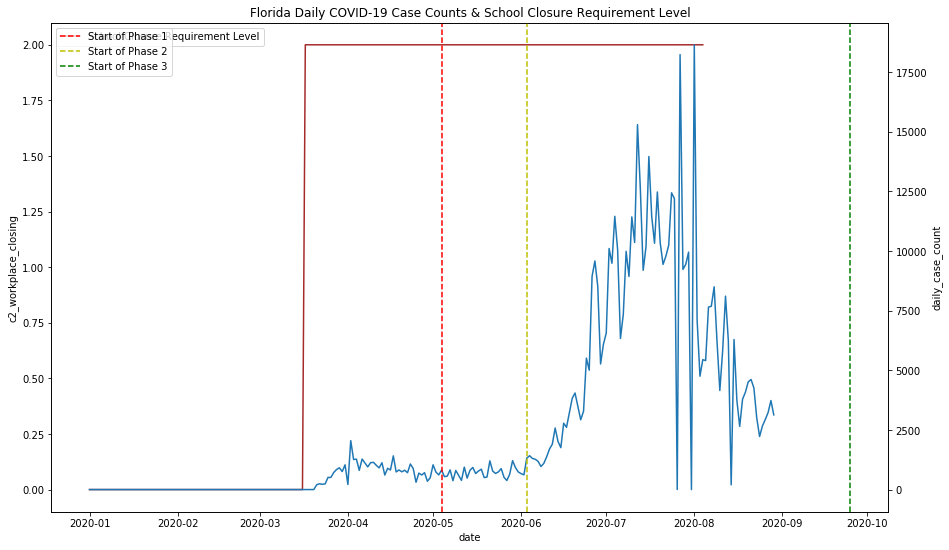

In [126]:
sns.lineplot(x='date' ,y='c2_workplace_closing', data=fl,c='brown', label='School Closure Requirement Level' )
plt.title('Florida Daily COVID-19 Case Counts & School Closure Requirement Level')
ax2 = plt.twinx()
sns.lineplot(y='daily_case_count', x ='date' ,data=dsc, ax=ax2)
plt.axvline(x=p1,label='Start of Phase 1', c='r',ls='--')
plt.axvline(x=p2,label='Start of Phase 2', c='y',ls='--')
plt.axvline(x=p3,label='Start of Phase 3', c='g',ls='--')
plt.legend(loc='best')

In [117]:

d1['nameoday']= pd.to_datetime(d1.date).dt.day_name()

In [118]:
d1[['day_of_week','nameoday']].head(50)

,day_of_week,nameoday
0,4.0,Friday
1,5.0,Saturday
2,6.0,Sunday
3,6.0,Sunday
4,0.0,Monday
5,0.0,Monday
6,1.0,Tuesday
7,1.0,Tuesday
9,2.0,Wednesday
8,2.0,Wednesday


In [120]:
d1.clinical_care_rank.describe()

count    12986.000000
mean        33.978284
std         19.333826
min          1.000000
25%         17.000000
50%         34.000000
75%         51.000000
max         67.000000
Name: clinical_care_rank, dtype: float64

In [130]:
# The county with the worst Clinical Care Rating
d1.loc[d1.clinical_care_rank == 67]['county'].unique()

array(['HENDRY'], dtype=object)

In [131]:
d1[['phase2','c6_stay_at_home_requirements']].corr(method ='spearman') 

,phase2,c6_stay_at_home_requirements
phase2,1.000000,-0.652946
c6_stay_at_home_requirements,-0.652946,1.000000


In [133]:
d1[['phase1','c6_stay_at_home_requirements']].corr(method ='spearman') 

,phase1,c6_stay_at_home_requirements
phase1,1.000000,0.059453
c6_stay_at_home_requirements,0.059453,1.000000
